In [2]:
from requests import get
import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.patches import Patch
from matplotlib.dates import DateFormatter 
import seaborn as sns


In [7]:
# HOSPITAL OCCUPANCY - fetch

api_params = {
    "areaType":"nhsRegion",
    "format":"json",
}

metrics = [
    "newAdmissions",
    "hospitalCases",
    "covidOccupiedMVBeds",
]

params = ""
for k,v in api_params.items():
    params += k + "=" + v + "&"
for v in metrics:
    params += "metric=" + v + "&"

response = get("https://api.coronavirus.data.gov.uk/v2/data?" + params, timeout=30)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

hosp_df = pd.DataFrame(response['body'])
hosp_df['dateTime']=pd.to_datetime(hosp_df['date'])
hosp_df.sort_values(by=['dateTime'], inplace=True)
#hosp_df.dropna(inplace=True)
nhsRegions = sorted(list(hosp_df.areaName.unique()))
print(nhsRegions) 

['East of England', 'London', 'Midlands', 'North East and Yorkshire', 'North West', 'South East', 'South West']


In [8]:

end_date_21 = datetime.datetime(year=2022,month=3,day=1)
start_date_21 = datetime.datetime(year=2021,month=12,day=1)
end_date_20 = end_date_21 - datetime.timedelta(days=365)
start_date_20 = start_date_21 - datetime.timedelta(days=365)
print(start_date_20, end_date_20)
print(start_date_21, end_date_21)
x_dates_21 = pd.date_range(start_date_21, end_date_21).to_list()
x_dates_20 = pd.date_range(start_date_20, end_date_20).to_list()

2020-12-01 00:00:00 2021-03-01 00:00:00
2021-12-01 00:00:00 2022-03-01 00:00:00


In [5]:
def N_avg(a, N=7):
    # hard edged convolution into past, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    for i in range(N-1):
        b[i] = np.nan
    for i in range(N-1,len(a),1):
        b[i] = np.mean(a[i-N+1:i+1])
    return b

def plot_comparison(title, x_dates, y_dict_20, y_dict_21, ylabel):
    # plot values of y_dict and a plot of corresponding growth rates across time
    sns.set_palette("CMRmap_r",len(y_dict_20))
    plt.clf()
    scale = 1
    n_avg = 3
    
    fig, ax1 = plt.subplots(1,1, figsize=(15*scale,5*scale))
    fig.suptitle(title, y=0.95)
    
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(MultipleLocator(14)) 
    
    for y_name,y in y_dict_21.items():
        ax1.plot(x_dates, N_avg(y, n_avg), label=y_name)
        ax1.set_ylabel(ylabel)
        
    handles, labels = ax1.get_legend_handles_labels()
    handles.append(Patch(facecolor='orange', edgecolor='r', alpha=0))
    labels.append("dashed lines are 2020 figures")
    ax1.legend(handles=handles, labels=labels, loc="upper left")
    
    for y_name,y in y_dict_20.items():
        ax1.plot(x_dates, N_avg(y, n_avg), label=y_name, ls="dashed", alpha=0.4)
        ax1.set_ylabel(ylabel)
        
    ax1.set_ylim(0,None)
    plt.savefig(title, dpi=300, bbox_inches="tight", pad_inches=0.1, facecolor='white', transparent=False)
    plt.show()

<Figure size 432x288 with 0 Axes>

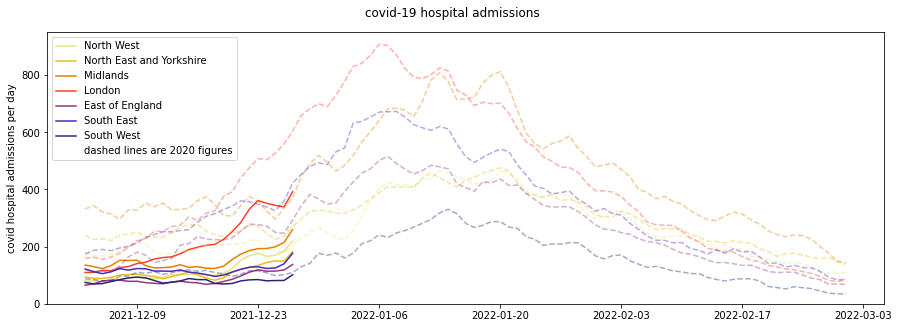

<Figure size 432x288 with 0 Axes>

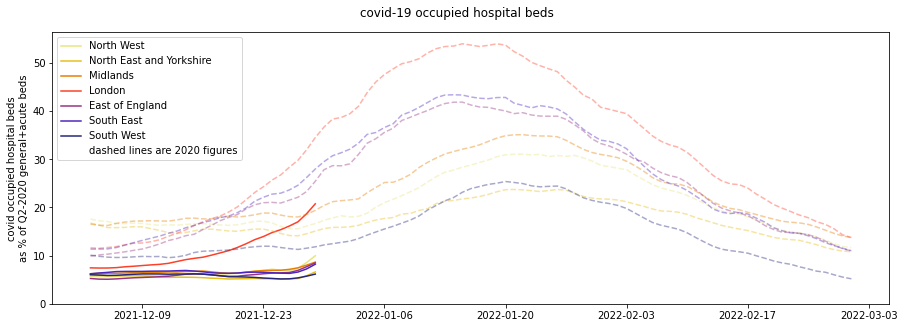

<Figure size 432x288 with 0 Axes>

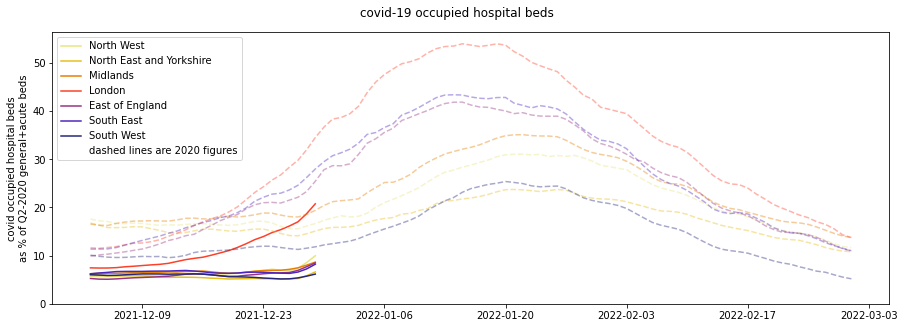

<Figure size 432x288 with 0 Axes>

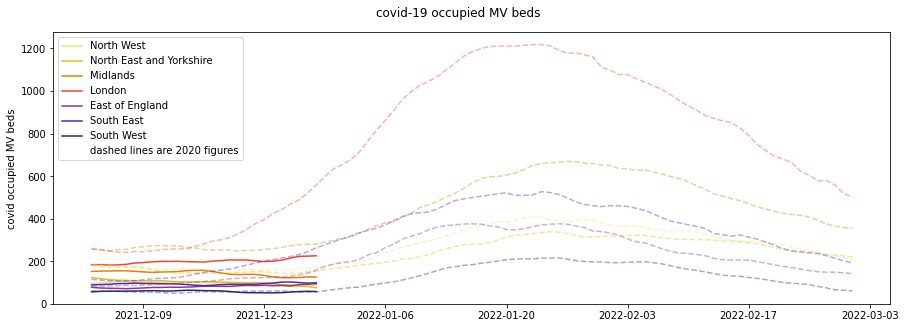

In [9]:
# HOSPITAL STUFF - plot_rates_over_time

nhsRegionOrder = ['North West', 'North East and Yorkshire', 'Midlands', 'London', 'East of England', 'South East', 'South West']
gen_acute_beds = {
    "London" : 14417,
    "South West" : 9261,
    "South East" : 12765,
    "Midlands" : 18113,
    "East of England" : 10255,
    "North West" : 13872,
    "North East and Yorkshire" : 16104,
}

## admissions
title = "covid-19 hospital admissions"
ylabel = "covid hospital admissions per day"

y_dict_20 = {}
y_dict_21 = {}
for nhsRegion in nhsRegionOrder:
    l = []
    for date in x_dates_21:
        _l = hosp_df[(hosp_df.areaName==nhsRegion) & (hosp_df.dateTime==date)].newAdmissions.to_list()
        l.append(_l[0] if len(_l)!=0 else np.nan)
    y_dict_21[nhsRegion] = np.array(l)
    l = []
    for date in x_dates_20:
        _l = hosp_df[(hosp_df.areaName==nhsRegion) & (hosp_df.dateTime==date)].newAdmissions.to_list()
        l.append(_l[0] if len(_l)!=0 else np.nan)
    y_dict_20[nhsRegion] = np.array(l)

plot_comparison(title, x_dates_21, y_dict_20, y_dict_21, ylabel)

## occupancy
title = "covid-19 occupied hospital beds"
ylabel = "covid occupied hospital beds\nas % of Q2-2020 general+acute beds"

y_dict_20 = {}
y_dict_21 = {}
for nhsRegion in nhsRegionOrder:
    l = []
    for date in x_dates_21:
        _l = hosp_df[(hosp_df.areaName==nhsRegion) & (hosp_df.dateTime==date)].hospitalCases.to_list()
        l.append(_l[0] if len(_l)!=0 else np.nan)
    y_dict_21[nhsRegion] = np.array(l)
    l = []
    for date in x_dates_20:
        _l = hosp_df[(hosp_df.areaName==nhsRegion) & (hosp_df.dateTime==date)].hospitalCases.to_list()
        l.append(_l[0] if len(_l)!=0 else np.nan)
    y_dict_20[nhsRegion] = np.array(l)
    y_dict_20[nhsRegion] /= gen_acute_beds[nhsRegion] 
    y_dict_21[nhsRegion] /= gen_acute_beds[nhsRegion] 
    y_dict_20[nhsRegion] *= 100
    y_dict_21[nhsRegion] *= 100

plot_comparison(title, x_dates_21, y_dict_20, y_dict_21, ylabel)

plot_comparison(title, x_dates_21, y_dict_20, y_dict_21, ylabel)

## mv beds
title = "covid-19 occupied MV beds"
ylabel = "covid occupied MV beds"

y_dict_20 = {}
y_dict_21 = {}
for nhsRegion in nhsRegionOrder:
    l = []
    for date in x_dates_21:
        _l = hosp_df[(hosp_df.areaName==nhsRegion) & (hosp_df.dateTime==date)].covidOccupiedMVBeds.to_list()
        l.append(_l[0] if len(_l)!=0 else np.nan)
    y_dict_21[nhsRegion] = np.array(l)
    l = []
    for date in x_dates_20:
        _l = hosp_df[(hosp_df.areaName==nhsRegion) & (hosp_df.dateTime==date)].covidOccupiedMVBeds.to_list()
        l.append(_l[0] if len(_l)!=0 else np.nan)
    y_dict_20[nhsRegion] = np.array(l)

plot_comparison(title, x_dates_21, y_dict_20, y_dict_21, ylabel)
